# Hysteresis Loops Fitting

In [1]:
import sys
sys.path.append('../../')
sys.path.append('../../src')

In [2]:
%load_ext autoreload
%autoreload 2

import h5py
import pyUSID as usid

from src.m3_learning.be.processing import fit_loop_function, loop_lsqf
from m3_learning.be.loop_fitter import loop_fitting_function_torch
from m3_learning.viz.layout import subfigures

import numpy as np

from m3_learning.nn.random import random_seed
from m3_learning.viz.style import set_style
from m3_learning.viz.printing import printer
from m3_learning.be.viz import Viz
from m3_learning.be.dataset import BE_Dataset
from m3_learning.be.nn import SHO_fit_func_nn, SHO_Model
from m3_learning.nn.Fitter1D.Fitter1D import Multiscale1DFitter, Model
# from m3_learning.nn.Fitter1D.Fitter1D_new import Multiscale1DFitter, Model
from m3_learning.be.filters import clean_interpolate

import torch

printing = printer(basepath = './Figures/')


set_style("printing")
random_seed(seed=42)

%matplotlib inline

2024-08-16 21:08:09.030372: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-16 21:08:09.030466: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-16 21:08:09.080939: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-16 21:08:09.189624: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-16 21:08:10.162901: W tensorflow/compiler/tf2

printing set for seaborn
Pytorch seed was set to 42
Numpy seed was set to 42
tensorflow seed was set to 42


In [3]:
from BGlib import be as belib


In [4]:
import pkg_resources

# Check the version of BGlib
bg_version = pkg_resources.get_distribution("BGlib").version
bg_version

/tmp/ipykernel_5374/616780478.py:1: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


'0.0.6'

In [5]:
pkg_resources.get_distribution("numpy").version

'1.26.4'

In [6]:
import sys
sys.version

'3.11.9 (main, Apr 19 2024, 16:48:06) [GCC 11.2.0]'

## Loads data

In [7]:
# Ensure python 3 compatibility
from __future__ import division, print_function, absolute_import

# Import necessary libraries:
# General utilities:
import os

# Computation:
import numpy as np
import h5py

# Visualization:
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# The engineering components supporting BGlib:
import sidpy
import pyUSID as usid
# Finally, BGlib itself
from BGlib import be as belib

# Make Notebook take up most of page width
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

# For the notebook to work you must have m3_learning installed
# pip install m3_learning
%load_ext autoreload
%autoreload 2

import numpy as np

from m3_learning.nn.random import random_seed
from m3_learning.viz.style import set_style
from m3_learning.util.file_IO import download_and_unzip
from m3_learning.viz.printing import printer
from m3_learning.be.viz import Viz
from m3_learning.be.dataset import BE_Dataset
from IPython.display import Video


# from m3_learning.be.dataset import BE_Dataset
printing = printer(basepath = './Figures/')

set_style("printing")
random_seed(seed=42)

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
printing set for seaborn
Pytorch seed was set to 42
Numpy seed was set to 42
tensorflow seed was set to 42


In [8]:
max_mem = 1024*8  # Maximum memory to use, in Mbs. Default = 1024
# Number of logical cores to use in fitting.  None uses all but 2 available cores.
max_cores = None
results_to_new_file = False

In [9]:
# Download the data file from Zenodo
url = 'https://zenodo.org/record/7774788/files/PZT_2080_raw_data.h5?download=1'

# Specify the filename and the path to save the file
filename = '/data_raw_7_25 copy.h5'
save_path = './Data'

# download the file
download_and_unzip(filename, url, save_path)

h5_path = save_path + filename

Using files already downloaded


In [10]:
# h5_path = "/home/ferroelectric/Documents/m3_learning/m3_learning/papers/2023_Rapid_Fitting/Data/data_raw_manual.h5"

h5_path = save_path + filename

folder_path, h5_raw_file_name = os.path.split(h5_path)
h5_file = h5py.File(h5_path, 'r+')
print('Working on:\n' + h5_path)

h5_main = usid.hdf_utils.find_dataset(h5_file, 'Raw_Data')[0]

# h5_main

Working on:
./Data/data_raw_7_25 copy.h5


In [11]:
print('Datasets and datagroups within the file:\n------------------------------------')
sidpy.hdf.hdf_utils.print_tree(h5_file)

print('\nThe main dataset:\n------------------------------------')
print(h5_main)

print('\nMetadata or attributes in the measurement datagroup\n------------------------------------')
for key, val in sidpy.hdf.hdf_utils.get_attributes(h5_main.parent.parent).items():
    print('{} : {}'.format(key, val))

Datasets and datagroups within the file:
------------------------------------
/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Bin_FFT
    ├ Bin_Frequencies
    ├ Bin_Indices
    ├ Bin_Step
    ├ Bin_Wfm_Type
    ├ Excitation_Waveform
    ├ Noise_Floor
    ├ Noisy_Data_1
    ├ Noisy_Data_2
    ├ Noisy_Data_3
    ├ Noisy_Data_4
    ├ Noisy_Data_5
    ├ Noisy_Data_6
    ├ Noisy_Data_7
    ├ Noisy_Data_8
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Spatially_Averaged_Plot_Group_000
      ---------------------------------
      ├ Bin_Frequencies
      ├ Max_Response
      ├ Mean_Spectrogram
      ├ Min_Response
      ├ Spectroscopic_Parameter
      ├ Step_Averaged_Response
    ├ Spatially_Averaged_Plot_Group_001
      ---------------------------------
      ├ Bin_Frequencies
      ├ Max_Response
      ├ Mean_Spectrogram
      ├ Min_Response
      ├ Spectroscopic_Parameter
      ├ Step_Averaged_Response
    ├ Spectroscopic_Indices
    ├ Spectr

In [12]:
# instantiate the dataset object
dataset = BE_Dataset(h5_path, SHO_fit_func_LSQF=SHO_fit_func_nn)


No spectroscopic datasets found as attributes of /Measurement_000/Channel_000/Position_Indices
No position datasets found as attributes of /Measurement_000/Raw_Data-SHO_Fit_000/Spectroscopic_Values


In [13]:
# print the contents of the file
dataset.print_be_tree()

/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Bin_FFT
    ├ Bin_Frequencies
    ├ Bin_Indices
    ├ Bin_Step
    ├ Bin_Wfm_Type
    ├ Excitation_Waveform
    ├ Noise_Floor
    ├ Noisy_Data_1
    ├ Noisy_Data_2
    ├ Noisy_Data_3
    ├ Noisy_Data_4
    ├ Noisy_Data_5
    ├ Noisy_Data_6
    ├ Noisy_Data_7
    ├ Noisy_Data_8
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Spatially_Averaged_Plot_Group_000
      ---------------------------------
      ├ Bin_Frequencies
      ├ Max_Response
      ├ Mean_Spectrogram
      ├ Min_Response
      ├ Spectroscopic_Parameter
      ├ Step_Averaged_Response
    ├ Spatially_Averaged_Plot_Group_001
      ---------------------------------
      ├ Bin_Frequencies
      ├ Max_Response
      ├ Mean_Spectrogram
      ├ Min_Response
      ├ Spectroscopic_Parameter
      ├ Step_Averaged_Response
    ├ Spectroscopic_Indices
    ├ Spectroscopic_Values
    ├ UDVS
    ├ UDVS_Indices
  ├ Raw_Data-SHO_Fit_000
    ----

In [14]:
h5_loop_fit, h5_loop_group = dataset.LSQF_Loop_Fit(force=False)

Consider calling test() to check results before calling compute() which computes on the entire dataset and writes results to the HDF5 file

Note: SHO_Fit has already been performed with the same parameters before. These results will be returned by compute() by default. Set override to True to force fresh computation

[<HDF5 group "/Measurement_000/Raw_Data-SHO_Fit_000" (8 members)>]

Note: SHO_Fit has already been performed with the same parameters before. These results will be returned by compute() by default. Set override to True to force fresh computation

[<HDF5 group "/Measurement_000/Raw_Data-SHO_Fit_000" (8 members)>]
Returned previously computed results at /Measurement_000/Raw_Data-SHO_Fit_000

Note: SHO_Fit has already been performed with the same parameters before. These results will be returned by compute() by default. Set override to True to force fresh computation

[<HDF5 group "/Measurement_000/Raw_Data-SHO_Fit_000" (8 members)>]
Returned previously computed results at /M

/home/ferroelectric/anaconda3/envs/paper/lib/python3.11/site-packages/pyUSID/io/hdf_utils/simple.py:888: UserWarning: A dataset named: Guess_Loop_Parameters already exists in group: /Measurement_000/Raw_Data-SHO_Fit_000/Fit-Loop_Fit_000
  warn('A dataset named: {} already exists in group: {}'.format(dset_name, h5_group.name))
/home/ferroelectric/anaconda3/envs/paper/lib/python3.11/site-packages/pyUSID/io/hdf_utils/simple.py:888: UserWarning: A dataset named: Fit_Loop_Parameters already exists in group: /Measurement_000/Raw_Data-SHO_Fit_000/Fit-Loop_Fit_000
  warn('A dataset named: {} already exists in group: {}'.format(dset_name, h5_group.name))


In [15]:
data_path = save_path + '/' + filename

dataset = BE_Dataset(data_path, SHO_fit_func_LSQF=SHO_fit_func_nn)

# instantiate the visualization object
image_scalebar = [2000, 500, "nm", "br"]


BE_viz = Viz(dataset, printing, verbose=True, 
             SHO_ranges = [(0,1.5e-4), (1.31e6, 1.33e6), (-300, 300), (-np.pi, np.pi)], 
             image_scalebar = image_scalebar)

No spectroscopic datasets found as attributes of /Measurement_000/Channel_000/Position_Indices
No position datasets found as attributes of /Measurement_000/Raw_Data-SHO_Fit_000/Spectroscopic_Values


In [75]:
BE_viz.hysteresis_comparison(data = ['LSQF'])

AttributeError: 'Viz' object has no attribute 'hysteresis_comparison'

## Neural Network Fits

In [16]:
from m3_learning.be.loop_fitter import loop_fitting_function_torch
from m3_learning.optimizers.TrustRegion import TRCG
import torch.optim as optim
from sklearn.model_selection import train_test_split


data, voltage = dataset.get_hysteresis(scaled=True, loop_interpolated = True)


model_ = Multiscale1DFitter(loop_fitting_function_torch, # function 
                            voltage[:,0].squeeze(), # x data
                            1, # input channels
                            9, # output parameters
                            dataset.loop_param_scaler,
                            loops_scaler=dataset.hysteresis_scaler)

# instantiate the model
model = Model(model_, 
              dataset,
              path='Trained Models/Hysteresis Fitter/', 
              training=True, 
              model_basename="Hysteresis_Loop_Fitter")

X_train, X_test = train_test_split(data.reshape(-1,96), test_size=0.2, random_state=42, shuffle=True)
X_train = np.atleast_3d(X_train)

optimizer = {
    "name": "TRCG", 
    "optimizer": TRCG,
    "closure_size": 1,
    "cgopttol": 1e-3,
    "c0tr": 0.2,
    "c1tr": 0.25,
    "c2tr": 0.75,
    "t1tr": 0.75,
    "t2tr": 2.0,
    "radius_max": 5.0,  
    "radius_initial": 1.0,
    "radius" : 1.0,
    "device": "cuda",
    "ADAM_epochs": 500}


train = False

if train:
    # fits the model
    model.fit(
        X_train,
        1024,
        optimizer=optimizer,
        epochs = 600,
    )
else:
    model.load(
        "/home/ferroelectric/Documents/m3_learning/m3_learning/papers/2023_Rapid_Fitting/Trained Models/Hysteresis Fitter/Hysteresis_Loop_Fitter_model_optimizer_Trust Region CG_epoch_599_train_loss_0.006924134410089917.pth"
    )

No spectroscopic datasets found as attributes of /Measurement_000/Channel_000/Position_Indices
No position datasets found as attributes of /Measurement_000/Raw_Data-SHO_Fit_000/Spectroscopic_Values
Using GPU NVIDIA GeForce RTX 3090


In [17]:
# model.training = False

In [18]:
 # predictions, params_scaled, params = model.predict(
 #        torch.Tensor(X_train), is_SHO=False)

In [19]:
# loop = loop_fitting_function_torch(params, voltage[:,0].squeeze()).to(
#     'cpu').detach().numpy().squeeze()

### Evaluate the Neural Network Results

In [20]:
# voltage[:,0].squeeze()

In [21]:
# self = BE_viz
# BE_viz.dataset.output_shape = 'pixel'

# data, voltage = dataset.get_hysteresis(scaled=True, loop_interpolated = True)
# data = torch.atleast_3d(torch.tensor(data.reshape(-1,96)))


# d1, d2, x1, x2, index1, mse1, _ = self.get_best_median_worst_hysteresis(
#                 data,
#                 prediction=model,
#                 n=1,
#             )


# parms = self.dataset.LSQF_hysteresis_params().reshape(-1,9)

# LSQF_loop = loop_fitting_function_torch(parms, voltage[:, 0].squeeze()).to(
#                     'cpu').detach().numpy().squeeze()

# unscaled_true = self.dataset.hystersis_scaler.inverse_transform(d1)
# unscaled_predicted = self.dataset.hystersis_scaler.inverse_transform(d2)

In [22]:
# plt.plot(voltage, unscaled_true[0])
# plt.plot(voltage, unscaled_predicted[0])
# plt.plot(voltage, LSQF_loop[index1[0]], 'k--')

In [28]:
type(model)

m3_learning.nn.Fitter1D.Fitter1D.Model

/tmp/ipykernel_5374/2178913270.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.atleast_3d(torch.tensor(X_train))
/home/ferroelectric/Documents/m3_learning/m3_learning/papers/2023_Rapid_Fitting/../../src/m3_learning/be/viz.py:1034: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(true).float()


./Figures/Figure_X_NN_validation_Train.png
./Figures/Figure_X_NN_validation_Train.svg


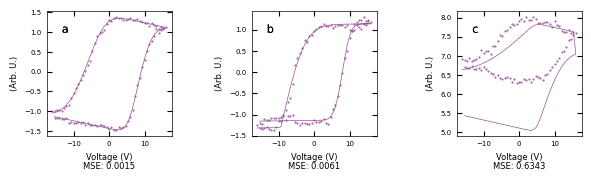

In [30]:
X_train = torch.atleast_3d(torch.tensor(X_train))

d1, d2, index1, mse1 = BE_viz.bmw_nn(
    X_train,
    prediction=model,
    returns=True,
    fit_type="hysteresis",
    filename="Figure_X_NN_validation_Train",
)

./Figures/Figure_X_NN_validation_Test.png
./Figures/Figure_X_NN_validation_Test.svg


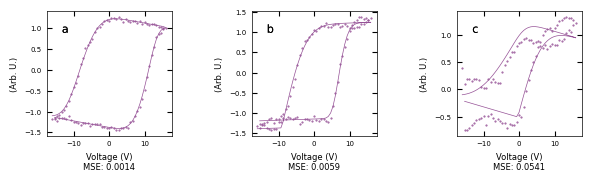

In [31]:
X_test = torch.atleast_3d(torch.tensor(X_test))

d1, d2, index1, mse1 = BE_viz.bmw_nn(
    X_test,
    prediction=model,
    returns=True,
    fit_type="hysteresis",
    filename="Figure_X_NN_validation_Test",
)

### Calculate the MSE

In [32]:
data_ = (torch.atleast_3d(torch.tensor(data.reshape(-1, 96))), X_test, X_train)
labels = ["Full Data", "Test Data", "Train Data"]

model.print_mse(data_, labels, is_SHO=False)

Full Data Mean Squared Error: 0.0069
Test Data Mean Squared Error: 0.0066
Train Data Mean Squared Error: 0.0070


## Comparison of LSQF and Neural Network Fits

3 graphs, best, median, worst

histograms of parameters.


In [ ]:
data_raw, voltage = BE_viz.dataset.get_hysteresis(
            scaled=True, loop_interpolated=True)

d1, d2, v1, v2, index1, mse1, params = BE_viz.get_best_median_worst_hysteresis(
            torch.atleast_3d(torch.tensor(data_raw.reshape(-1, 96))),
            prediction=model,
            n=1
            )

In [24]:
raw_hysteresis_loop, voltage = self.dataset.get_hysteresis(
        loop_interpolated=True, plotting_values=True)

No spectroscopic datasets found as attributes of /Measurement_000/Channel_000/Position_Indices
No position datasets found as attributes of /Measurement_000/Raw_Data-SHO_Fit_000/Spectroscopic_Values


In [33]:
def get_hysteresis_from_index(self, idx, nn_model):
    data, voltage = dataset.get_hysteresis(scaled=True, loop_interpolated = True)
    raw_hysteresis_loop, voltage = dataset.get_hysteresis(scaled=False, loop_interpolated = True)

    raw_hysteresis_loop = torch.atleast_3d(torch.tensor(raw_hysteresis_loop.reshape(-1,96)))[idx]
    data = torch.atleast_3d(torch.tensor(data.reshape(-1,96))).float()
    
    parms_LSQF = self.dataset.LSQF_hysteresis_params().reshape(-1,9)

    LSQF_loop = loop_fitting_function_torch(parms_LSQF, voltage[:, 0].squeeze()).to(
                        'cpu').detach().numpy().squeeze()
    
    LSQF_loop = LSQF_loop[idx]
    
    pred_data, scaled_params, params_nn = nn_model.predict(
            data, translate_params=False, is_SHO=False)
    
    NN_loop = loop_fitting_function_torch(params_nn, voltage[:, 0].squeeze()).to(
                        'cpu').detach().numpy().squeeze()
    
    NN_loop = NN_loop[idx]
    
    return raw_hysteresis_loop, LSQF_loop, NN_loop
    

In [142]:
# raw_hysteresis_loop, voltage = self.dataset.get_hysteresis(
#             loop_interpolated=True, plotting_values=True)

# parms = BE_viz.dataset.LSQF_hysteresis_params().reshape(-1, 9)
# loop = loop_fitting_function_torch(parms, voltage[:,0].squeeze()).to(
#     'cpu').detach().numpy().squeeze()

# raw_hysteresis_loop, voltage = self.dataset.get_hysteresis(
#             loop_interpolated=True, plotting_values=True)

# raw_hysteresis_loop = raw_hysteresis_loop.reshape(-1,96)

No spectroscopic datasets found as attributes of /Measurement_000/Channel_000/Position_Indices
No position datasets found as attributes of /Measurement_000/Raw_Data-SHO_Fit_000/Spectroscopic_Values
No spectroscopic datasets found as attributes of /Measurement_000/Channel_000/Position_Indices
No position datasets found as attributes of /Measurement_000/Raw_Data-SHO_Fit_000/Spectroscopic_Values


In [40]:
loops, raw_hysteresis_loop, voltage = BE_viz.dataset.get_LSQF_hysteresis_fits(compare=True)



No spectroscopic datasets found as attributes of /Measurement_000/Channel_000/Position_Indices
No position datasets found as attributes of /Measurement_000/Raw_Data-SHO_Fit_000/Spectroscopic_Values


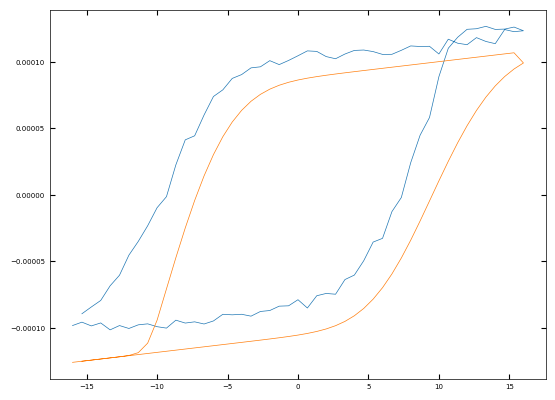

In [59]:

index = np.random.randint(0,14400)
plt.plot(voltage,raw_hysteresis_loop[index])
plt.plot(voltage, loops[index])

In [78]:

# # gets the projected loops
# h5_projected_loops = h5_f[ h5_path + '/Fit-Loop_Fit_000/Fit']

h5_path

'Measurement_000/Raw_Data-SHO_Fit_000/Fit-Loop_Fit_000'

In [64]:
# gets the path where the hysteresis loops are locate
h5_path = self.dataset.get_loop_path()

In [59]:
def hysteresis_comparison(self,
                              data,
                              row=None,
                              col=None,
                              cycle=None,
                              size=(1.25, 1.25),
                              gaps=(0.8, 0.33),
                              nn_model=None,
                              measurement_state=None,
                              filename="hysteresis_comparison"):
        """
        hysteresis_comparison function to plot a comparison of the hysteresis loop

        Args:
            data (list): List of data types to plot
            row (int, optional): row to plot. Defaults to None.
            col (int, optional): column to plot. Defaults to None.
            cycle (int, optional): cycle to plot. Defaults to None.
            size (tuple, optional): size of the image to plot. Defaults to (1.25,1.25).
            measurement_state (str, optional): measurement state to plot. Defaults to None.
        """

        # if not isinstance(models, list):
        #     models = [models]

        # sets the measurement state
        if self.dataset.measurement_state is not None:
            self.dataset.measurement_state = measurement_state

        # gets the raw data
        raw_hysteresis_loop, voltage = self.dataset.get_hysteresis(
            loop_interpolated=True, plotting_values=True)

        # if only the LSQF is to be plotted
        if 'LSQF' in data and 'NN' not in data:

            # selects a point to plot
            row, col, cycle = self.get_selected_hysteresis(
                raw_hysteresis_loop, row, col, cycle)
    
            self.random_hysteresis(raw_hysteresis_loop,
                          voltage,
                          filename,
                          size,
                          row, col, cycle)
            return

        # if we are plotting the NN and LSQF results
        fig, ax = subfigures(3, len(data), gaps=gaps, size=size)

        # # gets the NN object from the list
        # NN_model = next((model for model in models_list if isinstance(model, Fitter1D.Model)), None)
        
        # loops around the models provided
        for j, model in enumerate(data):

            if data == 'LSQF':
                prediction = self.dataset.get_hysteresis(loop_interpolated=True, plotting_values=True)[0]
            
            d1, d2, v1, v2, index1, mse1, params = BE_viz.get_best_median_worst_hysteresis(
            torch.atleast_3d(torch.tensor(raw_hysteresis_loop.reshape(-1, 96))),
            prediction=nn_model,
            n=1
            )
            
            for i, index in enumerate(index1):
                
                # sets the index for the plots
                plot_idx = i * 2 + j

                raw_hysteresis_loop, LSQF_loop, NN_loop = get_hysteresis_from_index(self, 
                                                                                index, nn_model)

                # # MSE between raw data and LSQF model
                # mse_LSQF = np.mean((raw_hysteresis_loop - torch.Tensor(LSQF_loop)) ** 2)
                
                # # MSE between raw data and NN model
                # mse_NN = np.mean((raw_hysteresis_loop - NN_loop) ** 2)

                ax[plot_idx].plot(voltage,
                                 raw_hysteresis_loop, 'o', label="Raw Data")

                ax[plot_idx].plot(voltage,
                                 LSQF_loop, 'r', label='LSQF')

                ax[plot_idx].plot(voltage,
                                 NN_loop, 'g', label='NN')
                

            #     # plot the raw data for LSQF
            #     ax[plot_idx].plot(voltage.squeeze()*-1,
            #                     raw_hysteresis_loop.reshape(-1, 96)[index1[i], :], 'o', label="Raw Data")

            #     # true_unscaled = self.dataset.hystersis_scaler.inverse_transform(
            #     #     true.reshape(-1, 1))

            #     # ax[plot_idx + 1].plot(voltage.squeeze(),
            #     #                     true_unscaled, 'o', label="Raw Data")

            #     # plot the NN prediction
            #     loop = loop_fitting_function_torch(parms.reshape(-1, 9), voltage[:, 0].squeeze()).to(
            #         'cpu').detach().numpy().squeeze()
            #     ax[plot_idx + 1].plot(v1.squeeze(),
            #                         loop.squeeze(), 'g', label='NN')

            #     # plot the LSQF prediction
                
            #     loop = loop_fitting_function_torch(parms_lsqf, voltage[:, 0].squeeze()).to(
            #         'cpu').detach().numpy().squeeze()
            #     ax[plot_idx].plot(
            #         v1.squeeze(),
            #         loop.squeeze(),
            #         "r",
            #         label='LSQF',
            #     )

            #     ax[plot_idx].set_xlabel("Voltage (V)")
            #     ax[plot_idx + 1].set_xlabel("Voltage (V)")

            #     # Position text at (1 inch, 2 inches) from the bottom left corner of the figure
            #     text_position_in_inches = (
            #         -1 * (gaps[0] + size[0]) * ((2 - i) % 3) + size[0] / 2,
            #         (gaps[1] + size[1]) * (1.25 - i // 3 - 1.25) - gaps[1],
            #     )

            #     # gets the axis position in inches - gets the bottom center
            #     center = get_axis_pos_inches(fig, ax[plot_idx + 1])

            #     # selects the text position as an offset from the bottom center
            #     text_position_in_inches = (center[0], center[1] - 0.33)

            #     error_string = f"MSE: {error:0.4f}"

            #     add_text_to_figure(
            #         fig,
            #         error_string,
            #         text_position_in_inches,
            #         fontsize=6,
            #         ha="center",
            #         # va="top",
            #     )

            #     ax[plot_idx].set_ylabel("(Arb. U.)")
            #     ax[plot_idx + 1].set_ylabel("(Arb. U.)")

            # add a legend just for the last one
            lines, labels = ax[plot_idx].get_legend_handles_labels()
            ax[plot_idx].legend(lines, labels, loc="upper right")
            lines, labels = ax[plot_idx+1].get_legend_handles_labels()
            ax[plot_idx+1].legend(lines, labels, loc="upper right")

            # # prints the figure
            # if self.Printer is not None and filename is not None:
            #     self.Printer.savefig(fig, filename, label_figs=ax, style="b")

No spectroscopic datasets found as attributes of /Measurement_000/Channel_000/Position_Indices
No position datasets found as attributes of /Measurement_000/Raw_Data-SHO_Fit_000/Spectroscopic_Values


/home/ferroelectric/Documents/m3_learning/m3_learning/papers/2023_Rapid_Fitting/../../src/m3_learning/be/viz.py:1034: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(true).float()


No spectroscopic datasets found as attributes of /Measurement_000/Channel_000/Position_Indices
No position datasets found as attributes of /Measurement_000/Raw_Data-SHO_Fit_000/Spectroscopic_Values
No spectroscopic datasets found as attributes of /Measurement_000/Channel_000/Position_Indices
No position datasets found as attributes of /Measurement_000/Raw_Data-SHO_Fit_000/Spectroscopic_Values
No spectroscopic datasets found as attributes of /Measurement_000/Channel_000/Position_Indices
No position datasets found as attributes of /Measurement_000/Raw_Data-SHO_Fit_000/Spectroscopic_Values
No spectroscopic datasets found as attributes of /Measurement_000/Channel_000/Position_Indices
No position datasets found as attributes of /Measurement_000/Raw_Data-SHO_Fit_000/Spectroscopic_Values
No spectroscopic datasets found as attributes of /Measurement_000/Channel_000/Position_Indices
No position datasets found as attributes of /Measurement_000/Raw_Data-SHO_Fit_000/Spectroscopic_Values
No spectro

/tmp/ipykernel_116038/1619529457.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.atleast_3d(torch.tensor(raw_hysteresis_loop.reshape(-1, 96))),
/home/ferroelectric/Documents/m3_learning/m3_learning/papers/2023_Rapid_Fitting/../../src/m3_learning/be/viz.py:1034: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(true).float()


TypeError: 'float' object is not subscriptable

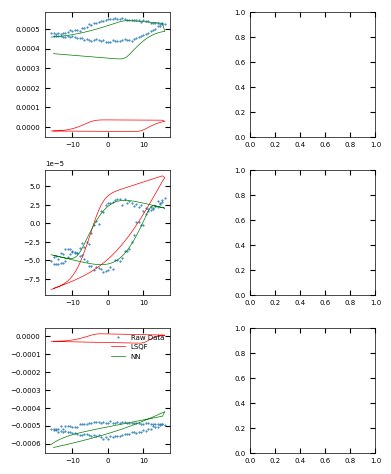

In [48]:
hysteresis_comparison(self,
                              ['LSQF','NN'],
                              row=None,
                              col=None,
                              cycle=None,
                              size=(1.25, 1.25),
                              gaps=(0.8, 0.33),
                              nn_model=model,
                              measurement_state=None,
                              filename="hysteresis_comparison")

No spectroscopic datasets found as attributes of /Measurement_000/Channel_000/Position_Indices
No position datasets found as attributes of /Measurement_000/Raw_Data-SHO_Fit_000/Spectroscopic_Values
No spectroscopic datasets found as attributes of /Measurement_000/Channel_000/Position_Indices
No position datasets found as attributes of /Measurement_000/Raw_Data-SHO_Fit_000/Spectroscopic_Values


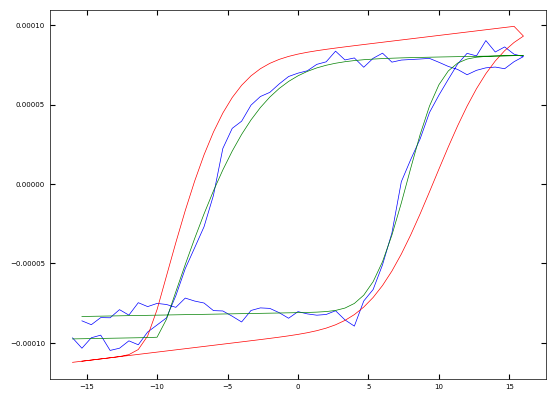

In [106]:
raw_hysteresis_loop, LSQF_loop, NN_loop = get_hysteresis_from_index(self, index1[1], model)
plt.plot(voltage, raw_hysteresis_loop, 'b')
plt.plot(voltage, LSQF_loop, 'r')
plt.plot(voltage, NN_loop, 'g')

In [ ]:
def hysteresis_comparison(self, models, )







d1, d2, x1, x2, index1, mse1, _ = self.get_best_median_worst_hysteresis(
                data,
                prediction=model,
                n=1,
            )




unscaled_true = self.dataset.hystersis_scaler.inverse_transform(d1)
unscaled_predicted = self.dataset.hystersis_scaler.inverse_transform(d2)

In [67]:
self = BE_viz

def get_hysteresis_prediction_from_ind(idx, model):
    # gets the raw data
    raw_hysteresis_loop, voltage = self.dataset.get_hysteresis(
        loop_interpolated=True, plotting_values=True)
    
    raw_hysteresis_loop = raw_hysteresis_loop.reshape(-1, 96)[idx, :]
    
    parms_lsqf = self.dataset.LSQF_hysteresis_params(
                ).reshape(-1, 9)[idx, :]
    
    data_raw, voltage = self.dataset.get_hysteresis(
        loop_interpolated=True, plotting_values=True)
    
    pred_data, scaled_params, params = model.predict(
            torch.atleast_3d(torch.tensor(data_raw.reshape(-1, 96))).float(), translate_params=False, is_SHO=False)
    
    params = params[idx, :].to(
                    'cpu').detach().numpy().squeeze()
    print(params.shape)
    print(type(parms_lsqf))
    
    LSQF_loop = loop_fitting_function_torch(parms_lsqf, voltage[:, 0].squeeze()).to(
                    'cpu').detach().numpy().squeeze()
    
    NN_loop = loop_fitting_function_torch(params, voltage[:, 0].squeeze()).to(
                    'cpu').detach().numpy().squeeze()
    
    return raw_hysteresis_loop, LSQF_loop, NN_loop

In [70]:
raw_hysteresis_loop, LSQF_loop, NN_loop = get_hysteresis_prediction_from_ind(index1[0], model)

No spectroscopic datasets found as attributes of /Measurement_000/Channel_000/Position_Indices
No position datasets found as attributes of /Measurement_000/Raw_Data-SHO_Fit_000/Spectroscopic_Values
No spectroscopic datasets found as attributes of /Measurement_000/Channel_000/Position_Indices
No position datasets found as attributes of /Measurement_000/Raw_Data-SHO_Fit_000/Spectroscopic_Values
(9,)
<class 'numpy.ndarray'>


In [1]:
plt.plot(voltage.squeeze()*-1, raw_hysteresis_loop, 'r', label="Raw Data")
plt.plot(voltage.squeeze(), LSQF_loop, 'b', label="Raw Data")
plt.plot(voltage.squeeze(), NN_loop, 'g', label="Raw Data")
plt.plot(voltage.squeeze(), d2[0], 'o', label="Raw Data")
plt.plot(voltage.squeeze(), d1[0], 'o', label="Raw Data")

NameError: name 'plt' is not defined

In [42]:
raw_hysteresis_loop.shape

(60, 60, 4, 96)

In [ ]:
def bmw_nn(
        self,
        true_state,
        prediction=None,
        model=None,
        out_state=None,
        n=1,
        gaps=(0.8, 0.33),
        size=(1.25, 1.25),
        filename=None,
        compare_state=None,
        fit_type='hysteresis',
        **kwargs,
    ):

No spectroscopic datasets found as attributes of /Measurement_000/Channel_000/Position_Indices
No position datasets found as attributes of /Measurement_000/Raw_Data-SHO_Fit_000/Spectroscopic_Values
No spectroscopic datasets found as attributes of /Measurement_000/Channel_000/Position_Indices
No position datasets found as attributes of /Measurement_000/Raw_Data-SHO_Fit_000/Spectroscopic_Values
./Figures/Figure_XX_LSQF_NN_bmw_comparison.png
./Figures/Figure_XX_LSQF_NN_bmw_comparison.svg


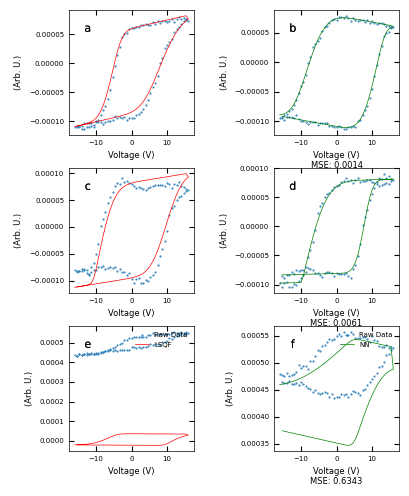

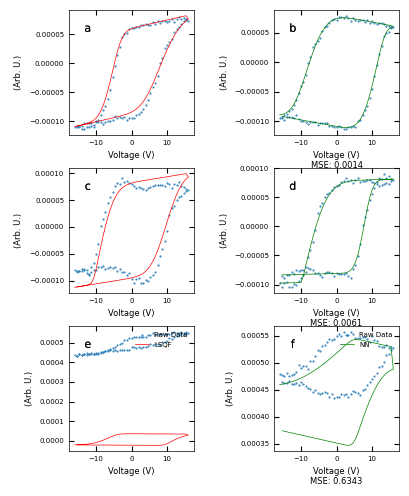

In [24]:
n = 1

data = ("LSQF", "NN")
# names = ["LSQF", "NN"]

BE_viz.get(
    data,
    model=model,
    filename="Figure_XX_LSQF_NN_bmw_comparison",
)

### Statistics of the Results for Training, Validation, and Entire Dataset

In [1]:
data, voltage = dataset.get_hysteresis(scaled=True, loop_interpolated = True)

BE_viz.violin_plot_comparison_hysteresis(model,
                                         torch.atleast_3d(torch.tensor(data.reshape(-1, 96))),
                                         filename="Figure_XX_Violin") 

NameError: name 'dataset' is not defined

### Color Maps of Parameters

In [ ]:
data, voltage = dataset.get_hysteresis(scaled=True, loop_interpolated = True)
data = torch.atleast_3d(torch.tensor(data.reshape(-1, 96)))

pred_recon, pred_params_scaled, pred_params = model.predict(
    data,
    1024,
    translate_params=False,
    is_SHO=False
)

BE_viz.hysteresis_maps(pred_params, filename="Figure_XX_NN_Hysteresis_Maps")